In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import getpass
import os
import csv

In [50]:
Vbeam = 6.32 # distance of vertical sample


plot_vert_prof = True # Plot vertical profile
save_vert_prof = False # Save vertical profile to file

plot_cross_sec = False

save_mid_depths = False

folder_file_save = "../output_images/{}.png"
folder_csv_save = "../data/{}.csv"
depths_adcp_for_adv = folder_csv_save.format('depths_adcp_for_adv_StreamPro')
##################################

In [51]:
# Number of days in total
numdays = 6

# Name of the computer
myhost = getpass.getuser()

# Base folder
datafolder = 'C:/Users/username/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/'.replace('username', myhost)# basefolder
basefolder = datafolder+'StreamPro'

# Subfolders
daynames = [i for i in os.listdir(basefolder)]

# Four different qs per time period
allqs = [np.zeros(numdays) for i in range(4)]


In [52]:
# Open Excel with ADV results
advexcel = datafolder+'ADVmeasurements.xlsx'

Monday afternoon
group 5_0_000_streampro_datatotal_ASC.TXT 0
group 5_0_002_streampro_datatotal_ASC.TXT 1
group 5_0_003_streampro_datatotal_ASC.TXT 0
group 5_0_004_streampro_datatotal_ASC.TXT 1
[0.437   0.4535  0.306   0.4245  0.31975 0.2745  0.2815 ] ['0.190', '0.240', '0.290', '0.340', '0.390', '0.440', '0.490']

Mean Qs 0
Mean right Q =  0.0024895525 m^3/s
Mean left Q =  -0.0037559275000000002 m^3/s
Mean top Q =  0.5095695125 m^3/s
Mean middle Q =  0.8426096925 m^3/s
Sum all 1.35715831

Monday morning
Station_0_000_streampro_datatotal_ASC.TXT 0
Station_0_001_streampro_datatotal_ASC.TXT 1
Station_0_002_streampro_datatotal_ASC.TXT 0
Station_0_003_streampro_datatotal_ASC.TXT 1
[0.3945  0.3865  0.316   0.332   0.2455  0.39425] ['0.190', '0.240', '0.290', '0.340', '0.390', '0.440']

Mean Qs 1
Mean right Q =  0.0007607624999999999 m^3/s
Mean left Q =  -0.00327424 m^3/s
Mean top Q =  0.5769443575 m^3/s
Mean middle Q =  0.9604669699999999 m^3/s
Sum all 1.5389328525

Tuesday afternoon
Group 7

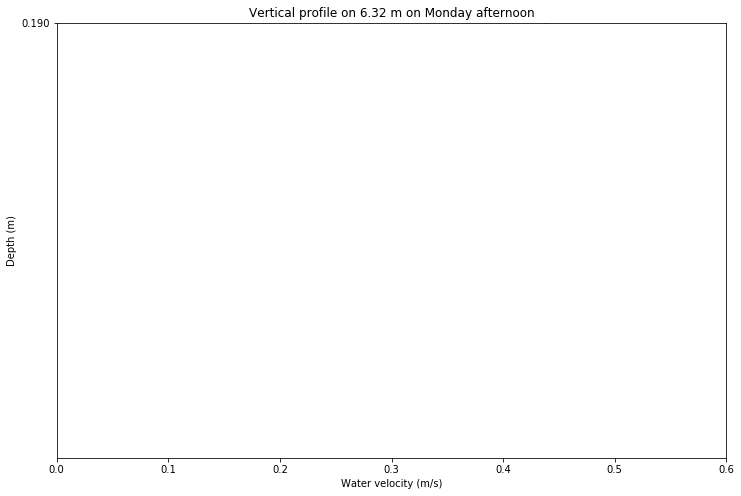

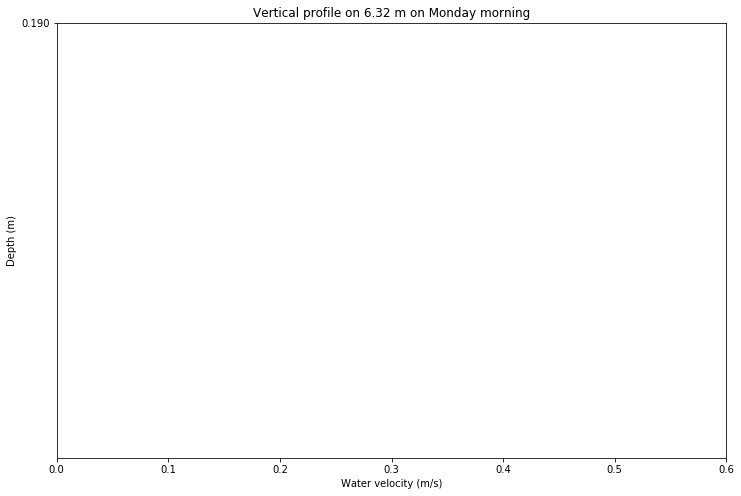

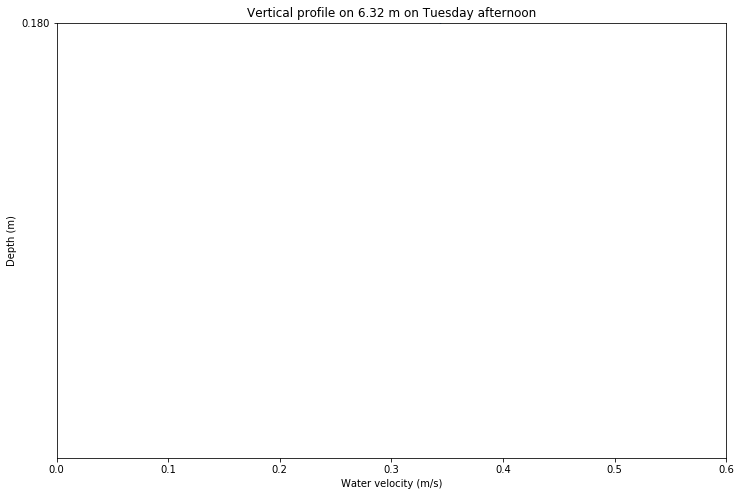

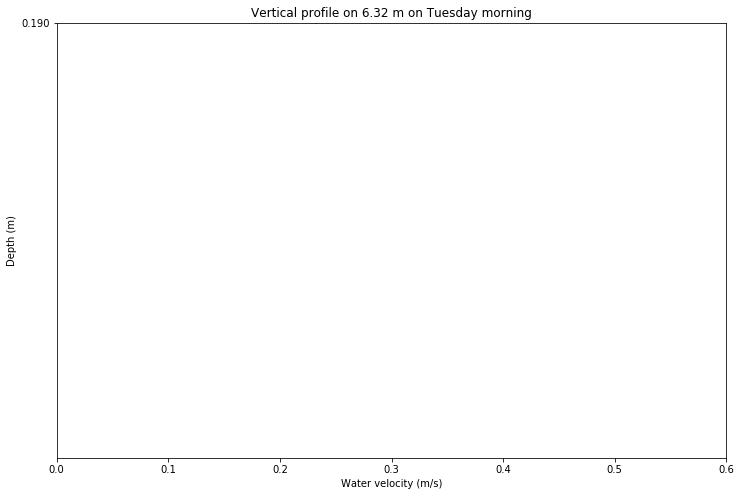

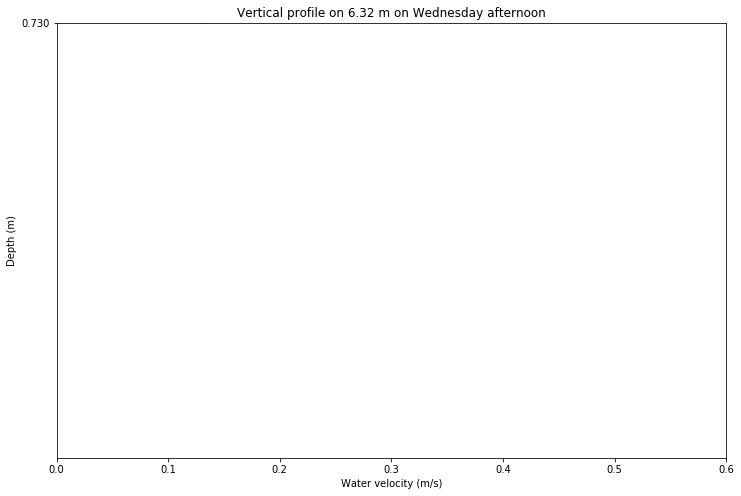

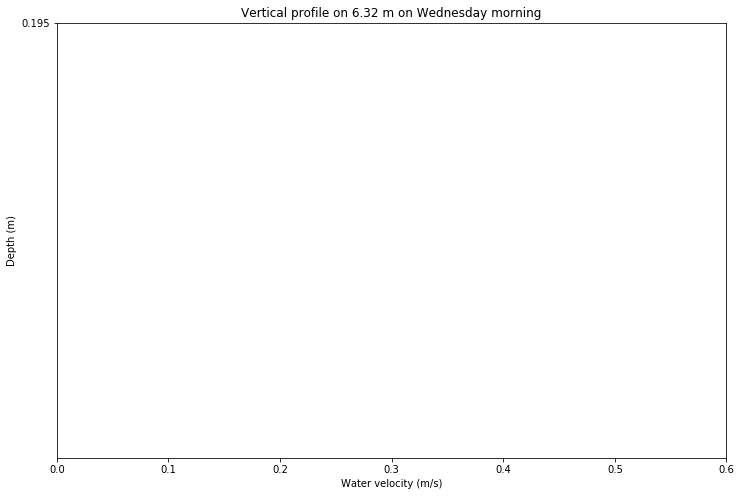

In [71]:
# Count the number of days
day = 0


# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=True):
  
    # Don't look in the basefolder
    if root == basefolder:
        continue
        
     # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # which folder are we doing right now?
    print(daynames[day])
    
    goodfiles =[file for file in files if file[-13:] == 'total_ASC.TXT']
    
    # Remember the number of the file
    filenum = 0
    
        # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    # Read the Excel of the ADV measurements
    adv = pd.read_excel(advexcel, sheet_name=daynames[day])
    meas_locs = adv.iloc[2, 1:].dropna()

    # Save depths in middle
    tot_middepths = np.zeros((len(meas_locs), len(goodfiles)))
 
    
    # Loop over the correct files in the folder
    for file in goodfiles:
        # Load direction from file in folder
        direction = int(np.loadtxt(root+'/direction.txt', delimiter = ',')[filenum])
        print(file, direction)
        
        
        data = pd.read_csv(root+'/'+file, delimiter = ';')
        
        # Water velocity in the direction of the river
        Velocity = data['northV'] #only the velocity to the north is in direction of the river
        Velocity = [Velocity.iloc[i].split(',') for i in range(len(Velocity))]
        for i in range(len(Velocity)):
            Velocity[i] = [float(Velocity[i][j]) for j in range(len(Velocity[i])) if float(Velocity[i][j])>-50]
            #velocity is negative for all days except Monday so need to change it to positive values
            if daynames[day][0] != 'M':
                Velocity[i] = [float(Velocity[i][j])*-1 for j in range(len(Velocity[i]))]  
       
        
        
        #corresponding depth of the bin with the velocity
        Depth_bin =data['depthbin'].iloc[0].split(',')
        
        
         #Total_width = data['totalwidth'].iloc[-1] #these values are not correct always the same
        
        #Bin_size = data['binsize'].iloc[0] Not needed
        
        # all the separate Qs
        TopQ = data['topQ'].iloc[-1]
                
        MiddleQ = data['middleQ'].iloc[-1]
        
        LeftQ = data['LeftQ'].iloc[-1]
        
        RightQ = data['RightQ'].iloc[-1]
        
        
         # Save total Qs such that average can be taken
        tot_rightq[filenum] = RightQ
        tot_leftq[filenum] = LeftQ
        tot_topq[filenum] = TopQ
        tot_middleq[filenum] = MiddleQ
             
        Distance = data['Distancetravelled']
        Distance = [Distance.iloc[i] for i in range(len(Distance))]
        
        if direction==1:  # flip if reverse
            Distance = np.max(Distance)-Distance
            
        # Depths in the measured area
        Middepths = [Depth_bin[len(Velocity[i])-1] if len(Velocity[i])>0 else np.nan for i in range(len(Velocity))]
        
        
        # Take out of the middle depths for comparison with the ADV
        for k in range(len(meas_locs)):
            dist_to_loc = np.array([abs(Distance[i]-meas_locs[k]) for i in range(len(Distance))])
            loc_cell = np.argmin(dist_to_loc)
            tot_middepths[k, filenum] = Middepths[loc_cell]
            
        dist_to_vbeam = np.array([abs(Distance[i]-Vbeam) for i in range(len(Distance))])
        
        Vbeam_cell = np.argmin(dist_to_vbeam)
        
        
        x_axis = Velocity[Vbeam_cell]
        y_axis = Depth_bin[0:len(Velocity[Vbeam_cell])]

        # x_axis = np.array([(x_axis[i]*2+x_axisplus1[i]+x_axisminus1[i])/4 for i in range(minsides)])
        tot_xs[file] = x_axis
        

        if len(x_axis) < len_xs:
            len_xs = len(x_axis)
            tot_ys = y_axis #[0:minsides]
        
        filenum +=1
        # Process the middle depth values
    if save_mid_depths:
        with open(depths_adcp_for_adv, 'a', newline = "") as csv_file:
            avg_middepths =  np.zeros(len(meas_locs))
            for i in range(len(meas_locs)):
                avg_middepths[i] = np.mean(tot_middepths[i, :])

            print("Depths in middle:")
            print(avg_middepths)

            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([daynames[day]]+[l for l in avg_middepths])

    
    
    # Process the vertical profile
    x_axis_tot = np.zeros(len_xs)
    
    for j in range(len_xs):     #depths
        level_tot = np.zeros(len(goodfiles))
        
        i = 0
        for file in goodfiles: #files
            level_tot[i] = tot_xs[file][j]
            i+=1
                
        x_axis_tot[j] = np.mean(level_tot)
    print(x_axis_tot, tot_ys)
    # Plot vertical velocity profile
    if plot_vert_prof:
        plt.figure(figsize=(12,8))
        plt.plot(x_axis_tot, tot_ys)
        plt.ylim((-.6,0))
        plt.xlim((0, 0.6))
        plt.xlabel('Water velocity (m/s)')
        plt.ylabel('Depth (m)')
        plt.title('Vertical profile on {} m on {}'.format(str(Vbeam), daynames[day]))
        if save_vert_prof:
            plt.savefig(folder_file_save.format('Vert_prof_vbeam_'+str(Vbeam).replace('.',',')+'_'+ daynames[day]))

    # Means of the Qs
    mean_rightq = np.mean(tot_rightq)
    mean_leftq = np.mean(tot_leftq)
    mean_topq = np.mean(tot_topq)
    mean_middleq = np.mean(tot_middleq)

    # Print means
    print()
    print('Mean Qs', day)
    print('Mean right Q = ', mean_rightq, 'm^3/s')
    print('Mean left Q = ', mean_leftq, 'm^3/s')
    print('Mean top Q = ', mean_topq, 'm^3/s')
    print('Mean middle Q = ', mean_middleq, 'm^3/s')
    print('Sum all', sum((mean_rightq, mean_rightq, mean_topq, mean_middleq)))

    # Save means
    allqs[0][day] = mean_rightq
    allqs[1][day] = mean_leftq
    allqs[2][day] = mean_topq
    allqs[3][day] = mean_middleq
        
    print()
    day +=1